In [1]:
import numpy as np
import h5py
import sys
import logging
sys.path.append('../')

# Neural network stuff
import sys,os
os.environ['THEANO_FLAGS'] = 'device=gpu,floatX=float32,optimizer_including=cudnn,optimizer=fast_run'
import theano

import data_iters.hdf5_iterator
from data_iters.hdf5_iterator import Hdf5MiniBatcher
from data_iters.minibatcher import MiniBatcher
import fielutil
from featextractor import extract_imfeats
import viz_tools.VizUtils, viz_tools.array_to_png
import stn

import keras
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical

%pylab inline

Using Theano backend.
Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


### File names

You will require:
1. HDF5 Files:
    a. Author-Lines
    b. Flat Images
2. Params (for the neural network you're looking at)

In [2]:
# Do you want to load the features in? Or save them to a file?
load_features = False

# All the images that you require extraction should be in this HDF5 file
# hdf5authors='nmecdata/nmec_scaled_author_form.hdf5'
#hdf5authors='/fileserver/nmec-handwriting/nmec_scaled_author_form.hdf5'
#hdf5authors='/fileserver/nmec-handwriting/author_nmec_bin_uint8.hdf5'
#hdf5images='/fileserver/nmec-handwriting/nmec_scaled_flat.hdf5'
hdf5authors='/fileserver/iam/iam-processed/words/author_words.hdf5'

# This is the file that you will load the features from or save the features to
# featurefile = 'icdar13data/benchmarking-processed/icdar13be_fiel657.npy'
# featurefile = 'icdar13data/experimental-processed/icdar13ex_fiel657.npy'
#featurefile = 'nmecdata/nmec_fiel657_features.npy'

# This is the neural networks and parameters you are deciding to use
#paramsfile = '/fileserver/iam/iam-processed/models/fiel_657.hdf5'

### Parameter Definitions

In [3]:
labels = h5py.File(hdf5authors, 'r')
num_authors=len(labels)
num_forms_per_author=-1
shingle_dim=(56,56)
batch_size=500
iterations = 1000
lr = 0.005

### Define your model

Here, we're using the Fiel Network

In [4]:
%pdb on
initial_scale=2
vnets = []

# competing models
vnets.append(fielutil.verbatimnet_stn( 'fc7', compiling=False, input_shape=(1, 56*initial_scale, 56*initial_scale), 
                                downsample_factor=initial_scale, 
                                lr=lr,
                                     scale_l2=0.05, translate_l2=0.05, off_diag_l1=0.5))
vnets.append(fielutil.verbatimnet( 'fc7', compiling=False, lr=lr ))

optimizers = []
optimizers.append(SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True))
optimizers.append(SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True))

#optimizers.append(Adam(lr=lr))
#optimizers.append(Adam(lr=lr))

for sgd, vnet in zip(optimizers, vnets):
    vnet.add(Dense(num_authors))
    vnet.add(Activation('softmax'))
    vnet.compile(loss='categorical_crossentropy', optimizer=sgd)

print "Finished compilation"

Automatic pdb calling has been turned ON
Finished compilation


### Minibatcher (to load in your data for each batch)

In [ ]:
# logging.getLogger('data_iters.hdf5_iterator').setLevel(logging.DEBUG)

def downsample(x,**kwargs):
    return viz_tools.array_to_png.rescale_img_array(x, 0.5)

def threshold(x,level=75,**kwargs):
    threshold_amount = np.percentile(x, level)
    return x * (x > threshold_amount).astype(x.dtype)

def binarize(x,**kwargs):
    return (x != 0).astype(x.dtype)

def postprocess(x, **kwargs):
    y = data_iters.hdf5_iterator.zero_one(x, **kwargs)
    # threshold and binarize
    y = threshold(y, 85)
    y = binarize(y)
    #assert y.shape==(56,56)
    return y


def postprocess2(x, **kwargs):
    y = data_iters.hdf5_iterator.zero_one(x, **kwargs)
    # threshold and binarize
    y = threshold(y, 85)
    y = binarize(y)
    y = viz_tools.array_to_png.rescale_img_array(y, 0.5)
    assert y.shape==(56,56)
    return y


def get_from_layer_function(model, layer_pos):
    XX = model.get_input()
    YY = model.layers[layer_pos].get_output()
    F = theano.function([XX], YY)
    return F

data_iterators=[]
double_size_shingle = tuple([2*a for a in shingle_dim])
# data for STN
data_iterators.append(Hdf5MiniBatcher(hdf5authors, num_authors, num_forms_per_author,
                            shingle_dim=double_size_shingle, default_mode=MiniBatcher.TRAIN,
                            batch_size=batch_size, add_rotation=False, rng_seed=1000,
                            stdev_threshold=25., postprocess=postprocess,))
# data for Fielnet
data_iterators.append(Hdf5MiniBatcher(hdf5authors, num_authors, num_forms_per_author,
                            shingle_dim=double_size_shingle, default_mode=MiniBatcher.TRAIN,
                            batch_size=batch_size, add_rotation=False, rng_seed=1000,
                            stdev_threshold=25., postprocess=postprocess2))

### Train your model for however many specified iterations

Automatic pdb calling has been turned OFF


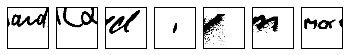

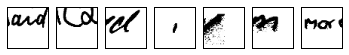

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.6237 - acc: 0.0020
Finished training on the 0th batch


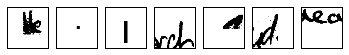

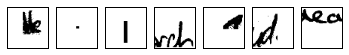

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.6271 - acc: 0.0020
Finished training on the 1th batch


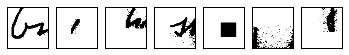

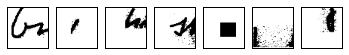

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.6110 - acc: 0.0040
Finished training on the 2th batch


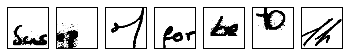

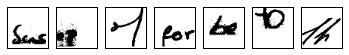

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.6224 - acc: 0.0040
Finished training on the 3th batch


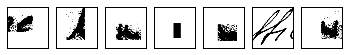

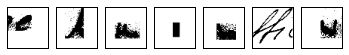

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.6152 - acc: 0.0080
Finished training on the 4th batch


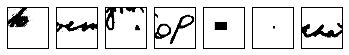

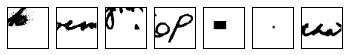

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.6060 - acc: 0.0060
Finished training on the 5th batch


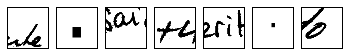

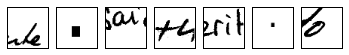

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.6069 - acc: 0.0140
Finished training on the 6th batch


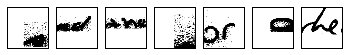

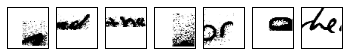

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5983 - acc: 0.0220
Finished training on the 7th batch


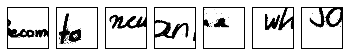

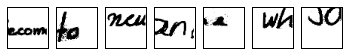

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5850 - acc: 0.0380
Finished training on the 8th batch


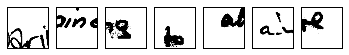

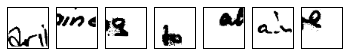

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5807 - acc: 0.0380
Finished training on the 9th batch


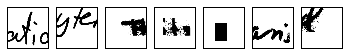

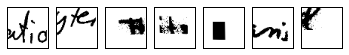

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5855 - acc: 0.0220
Finished training on the 10th batch


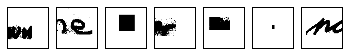

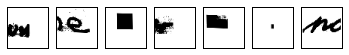

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5720 - acc: 0.0600
Finished training on the 11th batch


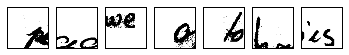

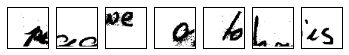

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5726 - acc: 0.0380
Finished training on the 12th batch


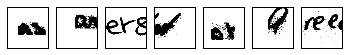

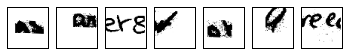

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5847 - acc: 0.0200
Finished training on the 13th batch


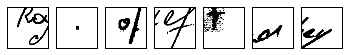

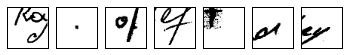

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5502 - acc: 0.0440
Finished training on the 14th batch


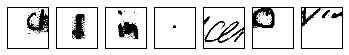

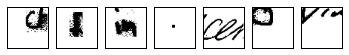

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5576 - acc: 0.0380
Finished training on the 15th batch


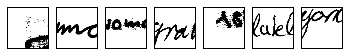

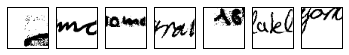

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5492 - acc: 0.0380
Finished training on the 16th batch


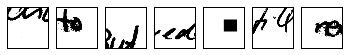

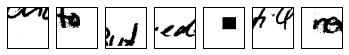

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5305 - acc: 0.0380
Finished training on the 17th batch


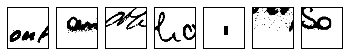

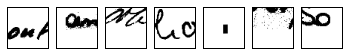

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5334 - acc: 0.0300
Finished training on the 18th batch


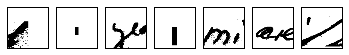

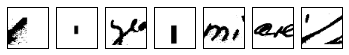

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5502 - acc: 0.0260
Finished training on the 19th batch


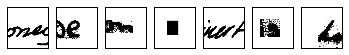

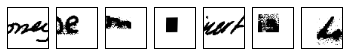

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5157 - acc: 0.0440
Finished training on the 20th batch


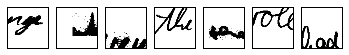

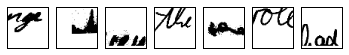

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4730 - acc: 0.0480
Finished training on the 21th batch


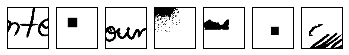

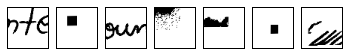

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5297 - acc: 0.0300
Finished training on the 22th batch


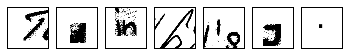

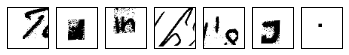

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.5050 - acc: 0.0320
Finished training on the 23th batch


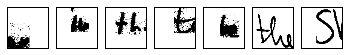

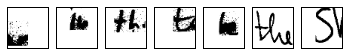

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4533 - acc: 0.0420
Finished training on the 24th batch


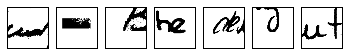

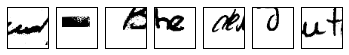

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4429 - acc: 0.0440
Finished training on the 25th batch


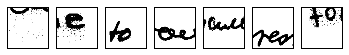

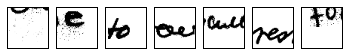

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4772 - acc: 0.0300
Finished training on the 26th batch


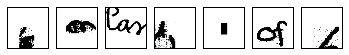

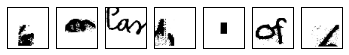

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4672 - acc: 0.0280
Finished training on the 27th batch


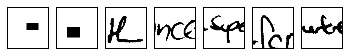

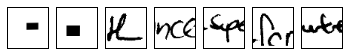

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4294 - acc: 0.0440
Finished training on the 28th batch


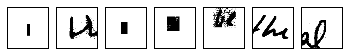

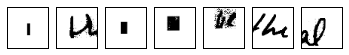

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4496 - acc: 0.0320
Finished training on the 29th batch


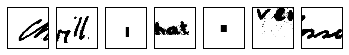

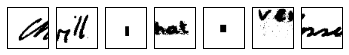

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4540 - acc: 0.0340
Finished training on the 30th batch


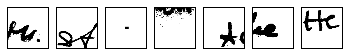

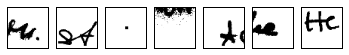

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4580 - acc: 0.0420
Finished training on the 31th batch


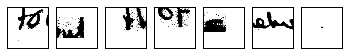

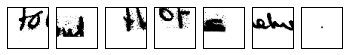

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4123 - acc: 0.0400
Finished training on the 32th batch


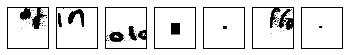

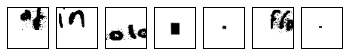

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4183 - acc: 0.0380
Finished training on the 33th batch


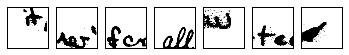

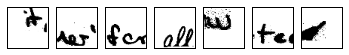

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4395 - acc: 0.0320
Finished training on the 34th batch


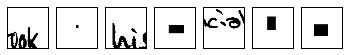

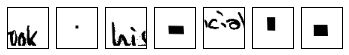

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4170 - acc: 0.0240
Finished training on the 35th batch


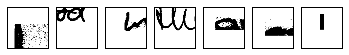

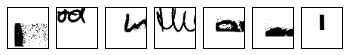

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4231 - acc: 0.0300
Finished training on the 36th batch


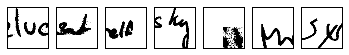

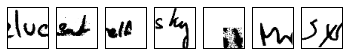

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4037 - acc: 0.0280
Finished training on the 37th batch


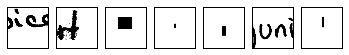

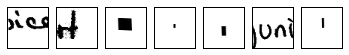

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3757 - acc: 0.0360
Finished training on the 38th batch


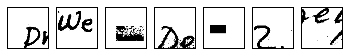

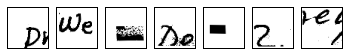

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4253 - acc: 0.0300
Finished training on the 39th batch


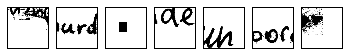

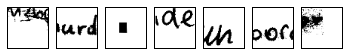

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3713 - acc: 0.0400
Finished training on the 40th batch


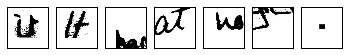

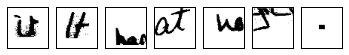

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4061 - acc: 0.0260
Finished training on the 41th batch


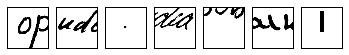

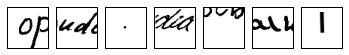

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3529 - acc: 0.0280
Finished training on the 42th batch


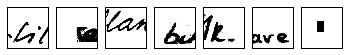

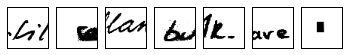

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3477 - acc: 0.0620
Finished training on the 43th batch


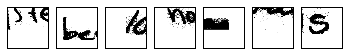

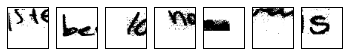

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3042 - acc: 0.0420
Finished training on the 44th batch


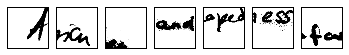

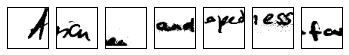

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.4187 - acc: 0.0220
Finished training on the 45th batch


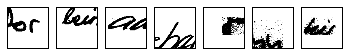

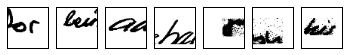

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3425 - acc: 0.0380
Finished training on the 46th batch


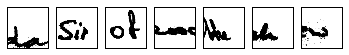

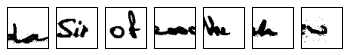

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3354 - acc: 0.0420
Finished training on the 47th batch


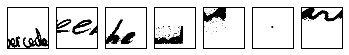

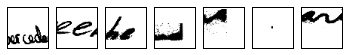

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3121 - acc: 0.0420
Finished training on the 48th batch


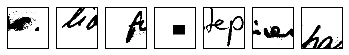

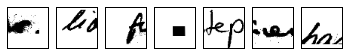

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3241 - acc: 0.0420
Finished training on the 49th batch


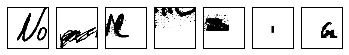

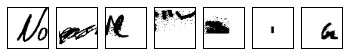

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.2683 - acc: 0.0360
Finished training on the 50th batch


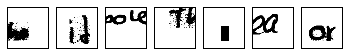

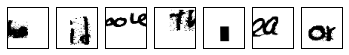

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3183 - acc: 0.0300
Finished training on the 51th batch


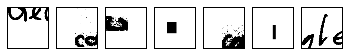

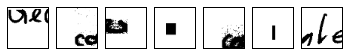

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3197 - acc: 0.0320
Finished training on the 52th batch


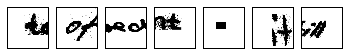

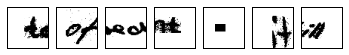

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3950 - acc: 0.0260
Finished training on the 53th batch


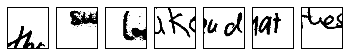

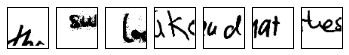

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.3187 - acc: 0.0260
Finished training on the 54th batch


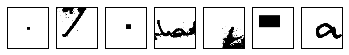

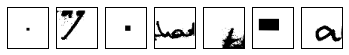

Epoch 1/1
500/500 [==============================] - 1s - loss: 6.2631 - acc: 0.0420

In [ ]:
%pdb off

first_past_post = []

for nmec_m, model in zip(data_iterators, vnets):
    inspect_layer = get_from_layer_function(model, 0)
    viz_interval = 1
    nb_examples_to_show = 7
    for batch_iter in range(iterations):
        (X_train,Y_train) = nmec_m.get_train_batch()
        if batch_iter % viz_interval == 0:
            plt.figure()
            viz_tools.VizUtils.plot_shingles(X_train, nb_examples_to_show, nb_examples_to_show)
            plt.show()

        X_train = np.expand_dims(X_train, 1).astype(np.float32)
        #assert not np.isnan(X_train).any()
        #for img_i in range(X_train.shape[0]):


        if batch_iter % viz_interval == 0:
           
            try:
                transformed_input = inspect_layer(X_train[:10].astype('float32'))
                plt.figure()
                viz_tools.VizUtils.plot_shingles(np.squeeze(transformed_input), nb_examples_to_show, nb_examples_to_show)
                plt.show()
            except TypeError as e:
                if str(e)=='Invalid dimensions for image data':
                    # image plotting doesn't work for non-STN flavor
                    print transformed_input.shape
                    pass
                else:
                    raise

        Y_train = to_categorical(Y_train, num_authors).astype('float32')
        v_history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1, show_accuracy=True, verbose=1)
        loss = v_history.history['loss'][0]
        if loss < 5.8:
            print "Got past 5.8 loss on Epoch {0}".format(batch_iter)
            first_past_post.append(batch_iter)
            break

        print "Finished training on the {0}th batch".format(batch_iter)
        if (batch_iter % 20)==0:
            #model.save_weights('fielnet-nmec.hdf5', overwrite=True)
            pass
print "STN: {0}\nFielnet: {1}".format(*first_past_post)